In [8]:
import json
import requests

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

# sns.set_palette('Set2')
# %matplotlib inline

Using TensorFlow backend.


In [9]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')

In [10]:
hist.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2012-10-27,10.26,10.84,9.82,10.17,47869.83,496747.54
2012-10-28,10.70,10.95,10.25,10.26,22389.59,236640.50
2012-10-29,10.60,10.94,10.32,10.70,37574.81,400173.50
2012-10-30,10.89,10.89,10.58,10.60,26023.32,279843.08
2012-10-31,11.20,11.21,10.71,10.89,40673.45,448359.79


In [11]:
target_col = 'close'

In [12]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [19]:
train, test = train_test_split(hist, test_size=0.1)

## Plot data

In [20]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18);

In [24]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='BTC')

## LSTM

In [25]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with respect to first entry. """
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    """ Normalise dataframe column-wise min/max. """
    return (df - df.min()) / (data.max() - df.min())

In [26]:
def extract_window_data(df, window_len=10, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of len `window_data`.
    
        :param window_len: Size of window
        :param zero_base: If True, the data in each window is normalised to reflect changes
            with respect to the first entry in the window (which is then always 0)
    """
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [27]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size=test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    # extract targets
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [28]:
def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [29]:
np.random.seed(42)

# data params
window_len = 7
test_size = 0.1
zero_base = True

# model params
lstm_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [30]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [33]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
1794/1794 [==============================] - 2s 1ms/step - loss: 0.0781
Epoch 2/50
1794/1794 [==============================] - 2s 860us/step - loss: 0.0526
Epoch 3/50
1794/1794 [==============================] - 2s 868us/step - loss: 0.0471
Epoch 4/50
1794/1794 [==============================] - 2s 895us/step - loss: 0.0433
Epoch 5/50
1794/1794 [==============================] - 2s 938us/step - loss: 0.0402
Epoch 6/50
1794/1794 [==============================] - 2s 941us/step - loss: 0.0400
Epoch 7/50
1794/1794 [==============================] - 2s 915us/step - loss: 0.0387
Epoch 8/50
1794/1794 [==============================] - 2s 898us/step - loss: 0.0375
Epoch 9/50
1794/1794 [==============================] - 2s 906us/step - loss: 0.0375
Epoch 10/50
1794/1794 [==============================] - 2s 866us/step - loss: 0.0366
Epoch 11/50
1794/1794 [==============================] - 2s 867us/step - loss: 0.0367
Epoch 12/50
1794/1794 [==============================] - 2s 864us

## Plot predictions

In [34]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

In [35]:
mean_absolute_error(preds, y_test)

0.04606342295670795

In [18]:
# 0.045261384613638447 with mae

In [36]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [39]:
n_points = 30

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction', lw=3)

In [40]:
line_plot(targets[-n_points:][:-1], preds[-n_points:].shift(-1), 'actual', 'prediction', lw=3)

## Compare returns

In [41]:
actual_returns = targets.pct_change()[1:]
predicted_returns = preds.pct_change()[1:]

In [42]:
def dual_line_plot(line1, line2, line3, line4, label1=None, label2=None, title='', lw=2):
    import matplotlib.dates as mdates
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 9))
    ax1.plot(line1, label=label1, linewidth=lw)
    ax1.plot(line2, label=label2, linewidth=lw)
    ax2.plot(line3, label=label1, linewidth=lw)
    ax2.plot(line4, label=label2, linewidth=lw)
    ax2.set_xticks(ax1.get_xticks())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.set_ylabel('daily returns', fontsize=14)
    ax2.legend(loc='best', fontsize=18);

In [43]:
dual_line_plot(actual_returns[-n_points:],
          predicted_returns[-n_points:],
          actual_returns[-n_points:][:-1],
          predicted_returns[-n_points:].shift(-1),
          'actual returns', 'predicted returns', lw=3)

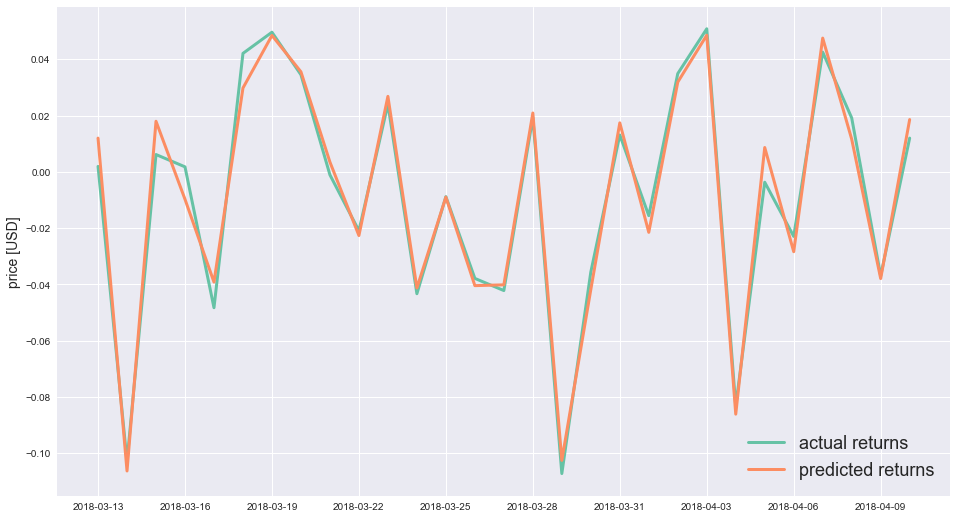

In [25]:
line_plot(actual_returns[-n_points:][:-1], predicted_returns[-n_points:].shift(-1),
           'actual returns', 'predicted returns', lw=3)

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# actual correlation
corr = np.corrcoef(actual_returns, predicted_returns)[0][1]
ax1.scatter(actual_returns, predicted_returns, color='k', marker='o', alpha=0.5, s=100)
ax1.set_title('r = {:.2f}'.format(corr), fontsize=18)

# shifted correlation
shifted_actual = actual_returns[:-1]
shifted_predicted = predicted_returns.shift(-1).dropna()
corr = np.corrcoef(shifted_actual, shifted_predicted)[0][1]
ax2.scatter(shifted_actual, shifted_predicted, color='k', marker='o', alpha=0.5, s=100)
ax2.set_title('r = {:.2f}'.format(corr), fontsize=18);